# Getting Started with Cloud-Native HLS Data in Python

## Extracting an EVI Time Series from Harmonized Landsat-8 Sentinel-2 (HLS) data in the Cloud using CMR's SpatioTemporal Asset Catalog (CMR-STAC)

### This tutorial demonstrates how to work with the HLS Landsat 8 ([HLSL30.002](https://doi.org/10.5067/HLS/HLSL30.002)) and Sentinel-2 ([HLSS30.002](https://doi.org/10.5067/HLS/HLSS30.002)) data products.

The  Harmonized Landsat Sentinel-2 ([HLS](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/)) project produces seamless, harmonized surface reflectance data from the Operational Land Imager (OLI) and Multi-Spectral Instrument (MSI) aboard Landsat-8 and Sentinel-2 Earth-observing satellites, respectively. The aim is to produce seamless products with normalized parameters, which include atmospheric correction, cloud and cloud-shadow masking, geographic co-registration and common gridding, normalized bidirectional reflectance distribution function, and spectral band adjustment. This will provide global observation of the Earth’s surface every 2-3 days with 30 meter spatial resolution. One of the major applications that will benefit from HLS is agriculture assessment and monitoring, which is used as the use case for this tutorial.  

NASA's Land Processes Distributed Active Archive Center (LP DAAC) archives and distributes HLS products in the LP DAAC Cumulus cloud archive as Cloud Optimized GeoTIFFs (COG). This tutorial will demonstrate how to query and subset HLS data using the NASA Common Metadata Repository (CMR) SpatioTemporal Asset Catalog (STAC) application programming interface (API). Because these data are stored as COGs, this tutorial will teach users how to load subsets of individual files into memory for just the bands you are interested in--a paradigm shift from the more common workflow where you would need to download a .zip/HDF file containing every band over the entire scene/tile. This tutorial covers how to process HLS data (quality filtering and EVI calculation), visualize, and "stack" the scenes over a region of interest into an [xarray](http://xarray.pydata.org/en/stable/) data array, calculate statistics for an EVI time series, and export as a comma-separated values (CSV) file--providing you with all of the information you need for your area of interest without having to download the source data file. The Enhanced Vegetation Index ([EVI](https://earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_4.php)), is a vegetation index similar to NDVI that has been found to be more sensitive to ground cover below the vegetated canopy and saturates less over areas of dense green vegetation.  

> **NOTE:** This tutorial no longer uses the <b>PROVISIONAL</b> Version 1.5 daily 30 meter (m) global Harmonized Landsat Sentinel-2 (HLS) Sentinel-2 Multi-spectral Instrument Surface Reflectance (HLSS30) product and the <b>PROVISIONAL</b> Version 1.5 daily 30 meter (m) global Harmonized Landsat Sentinel-2 (HLS) Landsat-8 OLI Surface Reflectance (HLSL30) data. </div>  

---

## Use Case Example

This tutorial was developed using an example use case for crop monitoring over a single large farm field in northern California. **The goal of the project is to observe HLS-derived mean EVI over a farm field in northern California without downloading the entirety of the HLS source data.**  

This tutorial will show how to use the CMR-STAC API to investigate the HLS collections available in the cloud and search for and subset to the specific time period, bands (layers), and region of interest for our use case, load subsets of the desired COGs into a Jupyter Notebook directly from the cloud, quality filter and calculate EVI, stack the time series, visualize the time series, and export a CSV of statistics on the EVI of the single farm field.  

---    

### Data Used in the Example  

- **Daily 30 meter (m) global HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance - [HLSS30.002](https://doi.org/10.5067/HLS/HLSS30.002)**
    - _The HLSS30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Sentinel-2A and Sentinel-2B MSI data products._  
     - **Science Dataset (SDS) layers:**  
        - B8A (NIR Narrow)  
        - B04 (Red)  
        - B02 (Blue)  
        - Fmask (Quality)    

- **Daily 30 meter (m) global HLS Landsat-8 OLI Surface Reflectance - [HLSL30.002](https://doi.org/10.5067/HLS/HLSL30.002)**
    - _The HLSL30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Landsat-8 OLI data products._  
     - **Science Dataset (SDS) layers:**  
        - B05 (NIR)  
        - B04 (Red)  
        - B02 (Blue)  
        - Fmask (Quality)  
        
---

## Topics Covered  

1. [**Getting Started**](#getstarted)  
    1.1 Import Packages and Set up the Working Environment         
2. [**Navigating the CMR-STAC API**](#navigatestac)      
    2.1 Introduction to the CMR-STAC API     
3. [**CMR-STAC API: Searching for Items**](#searchstac)      
    3.1 Spatial Querying via Bounding Box  
    3.2 Temporal Querying  
4. [**Extracting HLS COGs from the Cloud**](#extracthls)        
    4.1 Subset by Band   
    4.2 Load a Spatially Subset HLS COG into Memory  
5. [**Processing HLS Data**](#processhls)    
    5.1 Apply Scale Factor and Calculate EVI    
    5.2 Quality Filtering   
    5.3 Export to COG   
6. [**Automation**](#automation)     
7. [**Stacking HLS Data**](#stackhls)    
    7.1 Open COGs and Stack Using Xarray      
    7.2 Visualize Stacked Time Series  
    7.3 Export Statistics           

---

## Before Starting this Tutorial  

A [NASA Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to download the data used in this tutorial. You can create an account at the link provided.

You will also need to have a netrc file set up in your home directory in order to successfully run the code below. Check out the `Setting up a netrc File` section in the [README](https://git.earthdata.nasa.gov/projects/LPDUR/repos/hls-tutorial/browse/README.md).

---

## 1. Getting Started <a id="getstarted"></a>

### 1.1 Import Packages <a id="1.1"></a>

Import the required packages and set the input/working directory to run this Jupyter Notebook locally.

In [1]:
import os
from datetime import datetime
import requests as r
import numpy as np
import pandas as pd
import geopandas as gp
from skimage import io
import matplotlib.pyplot as plt
from osgeo import gdal
import rasterio as rio
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.shutil import copy
import pyproj
from pyproj import Proj
from shapely.ops import transform
import xarray as xr
import geoviews as gv
from cartopy import crs
import hvplot.xarray
import holoviews as hv
gv.extension('bokeh', 'matplotlib')

In [2]:
# Set Up Working Environment
inDir = os.getcwd()
os.chdir(inDir)

---

## 2. Navigating the CMR-STAC API <a id="navigatestac"></a>

In this section, we will learn about navigating NASA's Common Metadata Repository (CMR) SpatioTemporal Asset Catalog ([STAC](https://stacspec.org/)) API.  

### 2.1 Introduction to the CMR-STAC API <a id="2.1"></a>

#### What is STAC?

STAC is a specification that provides a common language for interpreting geospatial information in order to standardize indexing and discovering data. 

#### Four STAC Specifications

1. [STAC API](https://github.com/radiantearth/stac-api-spec)  
2. [STAC Catalog](https://github.com/radiantearth/stac-spec/blob/master/catalog-spec/catalog-spec.md)  
3. [STAC Collection](https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md)  
4. [STAC Item](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md)  

In the section below, we will walk through an example of each specification. For additional information, check out: https://stacspec.org/. 

#### 1. STAC API: Endpoint that enables the querying of STAC items.

Below, set the CMR-STAC API Endpoint to a variable, and use the `requests` package to send a GET request to the endpoint, and set the response to a variable.

In [4]:
stac = 'https://cmr.earthdata.nasa.gov/stac/'    # CMR-STAC API Endpoint
stac_response = r.get(stac).json()               # Call the STAC API endpoint
for s in stac_response: print(s)

id
title
stac_version
type
description
links


In [5]:
print(f"You are now using the {stac_response['id']} API (STAC Version: {stac_response['stac_version']}). {stac_response['description']}")
print(f"There are {len(stac_response['links'])} STAC catalogs available in CMR.")

You are now using the stac API (STAC Version: 1.0.0). This is the landing page for CMR-STAC. Each provider link contains a STAC endpoint.
There are 59 STAC catalogs available in CMR.


You will notice above that the CMR-STAC API contains many different endpoints--not just from NASA LP DAAC, but also contains endpoints for other NASA ESDIS DAACs.

#### 2. STAC Catalog: Contains a JSON file of links that organize all of the collections available. 

Below, search for LP DAAC Catalogs, and print the information contained in the Catalog that we will be using today, `LPCLOUD`.

In [5]:
stac_lp = [s for s in stac_response['links'] if 'LP' in s['title']]  # Search for only LP-specific catalogs

# LPCLOUD is the STAC catalog we will be using and exploring today
lp_cloud = r.get([s for s in stac_lp if s['title'] == 'LPCLOUD'][0]['href']).json()
for l in lp_cloud: print(f"{l}: {lp_cloud[l]}")

id: LPCLOUD
title: LPCLOUD
description: Root catalog for LPCLOUD
type: Catalog
stac_version: 1.0.0
links: [{'rel': 'self', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD', 'title': 'Provider catalog', 'type': 'application/json'}, {'rel': 'root', 'href': 'https://cmr.earthdata.nasa.gov/stac/', 'title': 'Root catalog', 'type': 'application/json'}, {'rel': 'collections', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections', 'title': 'Provider Collections', 'type': 'application/json'}, {'rel': 'search', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search', 'title': 'Provider Item Search', 'type': 'application/geo+json', 'method': 'GET'}, {'rel': 'search', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search', 'title': 'Provider Item Search', 'type': 'application/geo+json', 'method': 'POST'}, {'rel': 'conformance', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/conformance', 'title': 'Conformance Classes', 'type': 'application/geo+json'}, {'rel': 'ser

Below, print the links contained in the LPCLOUD STAC Catalog:

In [6]:
lp_links = lp_cloud['links']
for l in lp_links: 
    try: 
        print(f"{l['href']} is the {l['title']}")
    except:
        print(f"{l['href']}")       

https://cmr.earthdata.nasa.gov/stac/LPCLOUD is the Provider catalog
https://cmr.earthdata.nasa.gov/stac/ is the Root catalog
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections is the Provider Collections
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search is the Provider Item Search
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search is the Provider Item Search
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/conformance is the Conformance Classes
https://api.stacspec.org/v1.0.0-beta.1/openapi.yaml is the OpenAPI Doc
https://api.stacspec.org/v1.0.0-beta.1/index.html is the HTML documentation
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/ASTGTM.v003
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSL30.v2.0
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSL30.v1.5
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v1.5
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v2.0


#### 3. STAC Collection: Extension of STAC Catalog containing additional information that describe the STAC Items in that Collection.

Below, get a response from the LPCLOUD Collection and print the information included in the response.

In [7]:
lp_collections = [l['href'] for l in lp_links if l['rel'] == 'collections'][0]  # Set collections endpoint to variable
collections_response = r.get(f"{lp_collections}").json()                        # Call collections endpoint
print(f"This collection contains {collections_response['description']} ({len(collections_response['collections'])} available)")

This collection contains All collections provided by LPCLOUD (5 available)


Print the STAC Collection information for HLSL30 version 2.0:

In [8]:
collections = collections_response['collections']
collections[1]

{'id': 'HLSL30.v2.0',
 'stac_version': '1.0.0',
 'license': 'not-provided',
 'title': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0',
 'type': 'Collection',
 'description': 'The Harmonized Landsat Sentinel-2 (HLS) project provides consistent surface reflectance (SR) and top of atmosphere (TOA) brightness data from the Operational Land Imager (OLI) aboard the joint NASA/USGS Landsat 8 satellite and the Multi-Spectral Instrument (MSI) aboard Europe’s Copernicus Sentinel-2A and Sentinel-2B satellites. The combined measurement enables global observations of the land every 2–3 days at 30-meter (m) spatial resolution. The HLS project uses a set of algorithms to obtain seamless products from OLI and MSI that include atmospheric correction, cloud and cloud-shadow masking, spatial co-registration and common gridding, illumination and view angle normalization, and spectral bandpass adjustment.\r\n\r\nThe HLSL30 product provides 30-m Nadir Bidir

In `id` STAC field is used to query by a specific product. Be sure to save this ID for the HLS S30 and L30 v2.0 products below:

In [9]:
# Search available version 2 collections for HLS and print them out
hls_collections = [c for c in collections if 'HLS' in c['id'] and 'v2' in c['id']]
for h in hls_collections: 
    print(f"{h['title']} has an ID (shortname) of: {h['id']}")

HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0 has an ID (shortname) of: HLSL30.v2.0
HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance Daily Global 30m v2.0 has an ID (shortname) of: HLSS30.v2.0


Notice that the STAC field `id` is in the format: productshortname.vM.m (where M = major product version and m = minor product version)

Explore the attributes contained in the HLSS30 Collection.

In [10]:
s30 = [h for h in hls_collections if 'HLSS30' in h['id']][0]    # Grab HLSS30 collection

for s in s30['extent']:                                         # Check out the extent of this collection
    print(f"{s}: {s30['extent'][s]}")

spatial: {'bbox': [[-180, -90, 180, 90]]}
temporal: {'interval': [['2015-12-01T00:00:00.000Z', None]]}


Here we can see above that the extent is global. We can also see the temporal range, where "None" means on-going or to present.

Print the start date for HLSL30

In [11]:
print(f"HLS S30 Start Date is: {s30['extent']['temporal']['interval'][0][0]}")

HLS S30 Start Date is: 2015-12-01T00:00:00.000Z


Next, explore the attributes of the HLSL30 collection.

In [12]:
l30 = [h for h in hls_collections if 'HLSL30' in h['id'] and 'v2.0' in h['id']][0]     # Grab HLSL30 collection

for l in l30['extent']:                                                                # Check out the extent of this collection
    print(f"{l}: {l30['extent'][l]}")             

spatial: {'bbox': [[-180, -90, 180, 90]]}
temporal: {'interval': [['2013-05-01T00:00:00.000Z', None]]}


Print the start date for HLSL30

In [13]:
print(f"HLS L30 Start Date is: {l30['extent']['temporal']['interval'][0][0]}")

HLS L30 Start Date is: 2013-05-01T00:00:00.000Z


Above, notice that the L30 product has a different start date than the S30 product. 

#### 4. STAC Item: Represents data and metadata assets that are spatiotemporally coincident

Below, query the HLSS30 collection for items and return the first item in the collection. 

In [14]:
# Below, go through all links in the collection and return the link containing the items endpoint
s30_items = [s['href'] for s in s30['links'] if s['rel'] == 'items'][0]    # Set items endpoint to variable
s30_items

'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v2.0/items'

In [15]:
s30_items_response = r.get(f"{s30_items}").json()    # Call items endpoint
s30_item = s30_items_response['features'][0]         # select first item (10 items returned by default)
s30_item

{'type': 'Feature',
 'id': 'HLS.S30.T36UUA.2020008T090341.v2.0',
 'stac_version': '1.0.0',
 'stac_extensions': ['https://stac-extensions.github.io/eo/v1.0.0/schema.json'],
 'collection': 'HLSS30.v2.0',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[30.2359027, 49.5317312],
    [31.752783, 49.558034],
    [31.7269244, 50.5453332],
    [30.1786675, 50.5181],
    [30.2359027, 49.5317312]]]},
 'bbox': [30.178667, 49.531731, 31.752783, 50.545333],
 'links': [{'rel': 'self',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v2.0/items/HLS.S30.T36UUA.2020008T090341.v2.0'},
  {'rel': 'parent',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v2.0'},
  {'rel': 'collection',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v2.0'},
  {'rel': 'root', 'href': 'https://cmr.earthdata.nasa.gov/stac/'},
  {'rel': 'provider', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD'},
  {'rel': 'via',
   'href': 'https://cmr.

STAC metadata provides valuable information on the item, including a unique ID, when it was acquired, the location of the observation, and a cloud cover assessment.  

In [16]:
# Print metadata attributes from this observation
print(f"The ID for this item is: {s30_item['id']}")
print(f"It was acquired on: {s30_item['properties']['datetime']}")
print(f"over: {s30_item['bbox']} (Lower Left, Upper Right corner coordinates)")
print(f"It contains {len(s30_item['assets'])} assets")
print(f"and is {s30_item['properties']['eo:cloud_cover']}% cloudy.")

The ID for this item is: HLS.S30.T36UUA.2020008T090341.v2.0
It was acquired on: 2020-01-08T09:06:20.044Z
over: [30.178667, 49.531731, 31.752783, 50.545333] (Lower Left, Upper Right corner coordinates)
It contains 20 assets
and is 16% cloudy.


Below, print out the ten items and the percent cloud cover--we will use this to decide which item to visualize in the next section. 

In [17]:
for i, s in enumerate(s30_items_response['features']):
    print(f"Item at index {i} is {s['properties']['eo:cloud_cover']}% cloudy.")

Item at index 0 is 16% cloudy.
Item at index 1 is 0% cloudy.
Item at index 2 is 1% cloudy.
Item at index 3 is 6% cloudy.
Item at index 4 is 15% cloudy.
Item at index 5 is 7% cloudy.
Item at index 6 is 100% cloudy.
Item at index 7 is 100% cloudy.
Item at index 8 is 18% cloudy.
Item at index 9 is 1% cloudy.


Using the information printed above, set the `item_index` to interrogate the STAC Item and visualize the browse image.

In [18]:
item_index = 0    # Indexing starts at 0 in Python, so here select the eighth item in the list at index 0

In [19]:
s30_item = s30_items_response['features'][item_index]    # Grab the next item in the list

print(f"The ID for this item is: {s30_item['id']}")
print(f"It was acquired on: {s30_item['properties']['datetime']}")
print(f"over: {s30_item['bbox']} (Lower Left, Upper Right corner coordinates)")
print(f"It contains {len(s30_item['assets'])} assets")
print(f"and is {s30_item['properties']['eo:cloud_cover']}% cloudy.")

The ID for this item is: HLS.S30.T36UUA.2020008T090341.v2.0
It was acquired on: 2020-01-08T09:06:20.044Z
over: [30.178667, 49.531731, 31.752783, 50.545333] (Lower Left, Upper Right corner coordinates)
It contains 20 assets
and is 16% cloudy.


Below, print out the names of all of the assets included in this item.

In [20]:
print("The following assets are available for download:")
for a in s30_item['assets']: print(a)

The following assets are available for download:
B03
VZA
SAA
B06
B01
B09
B05
SZA
VAA
B04
B10
B08
B02
Fmask
B11
B12
B07
B8A
browse
metadata


Notice that each HLS item includes a browse image. Read the browse file into memory and visualize the HLS acquisition.

In [21]:
s30_item['assets']['browse']

{'title': 'Download HLS.S30.T36UUA.2020008T090341.v2.0.jpg',
 'href': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/HLSS30.020/HLS.S30.T36UUA.2020008T090341.v2.0/HLS.S30.T36UUA.2020008T090341.v2.0.jpg',
 'type': 'image/jpeg'}

Use the `skimage` package to load the browse image into memory and `matplotlib` to quickly visualize it.

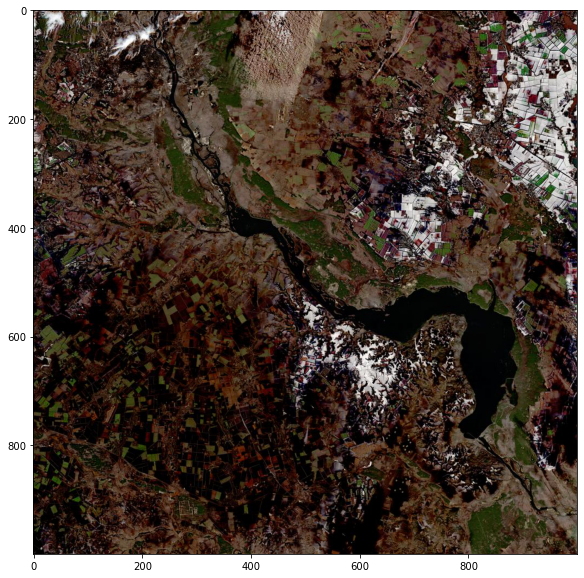

In [22]:
%matplotlib inline

image = io.imread(s30_item['assets']['browse']['href'])    # Load jpg browse image into memory

# Basic plot of the image
plt.figure(figsize=(10,10))              
plt.imshow(image)
plt.show()

Congrats! You have pulled your first HLS asset from the cloud using STAC! 

Below, we will remove variables that were set in sections 1-2 that we will no longer use for the duration of the tutorial. This is good practice in order to keep a clean environment and to save space in memory.

In [23]:
# Remove unnecessary variables
del image, s30_items, s30_items_response, stac_lp, stac_response, l30
del a, collections, collections_response, h, hls_collections, l, lp_cloud, lp_collections, s, s30, s30_item

---

## 3. CMR-STAC API: Searching for Items <a id="searchstac"></a>

In this section, instead of simply navigating through the structure of a STAC Catalog, use the search endpoint to query the API by region of interest and time period of interest.

### 3.1 Spatial Querying via Bounding Box <a id="3.1"></a>

The search endpoint is one of the links found in the  `LPCLOUD` STAC Catalog, which can be leveraged to retrieve STAC Items that match the submitted query parameters.

Grab the search endpoint for the `LPCLOUD` STAC Catalog and send a POST request to retrieve items.

In [24]:
lp_search = [l['href'] for l in lp_links if l['rel'] == 'search'][0]    # Define the search endpoint

# Set up a dictionary that will be used to POST requests to the search endpoint
params = {}

In [25]:
search_response = r.post(lp_search, json=params).json()    # Send POST request to retrieve items
print(f"{len(search_response['features'])} items found!")

10 items found!


If we just call the search endpoint directly, it will default to returning the first 10 granules. Below, set a limit to return the first 100 matching items. Additional information on the spec for adding parameters to a search query can be found at: https://github.com/radiantearth/stac-api-spec/tree/master/item-search#query-parameters-and-fields. 

In [26]:
lim = 100
params['limit'] = lim  # Add in a limit parameter to retrieve 100 items at a time.
print(params)

{'limit': 100}


Above, we have added the limit as a parameter to the dictionary that we will post to the search endpoint to submit our request for data. As we keep moving forward in the tutorial, we will continue adding parameters to the `params` dictionary.

In [27]:
search_response = r.post(lp_search, json=params).json()  # send POST request to retrieve first 100 items in the STAC collection

print(f"{len(search_response['features'])} items found!")

100 items found!


Next, load in the spatial region of interest for our use case using `geopandas`. You will need to have downloaded the [Field_Boundary.geojson](https://git.earthdata.nasa.gov/projects/LPDUR/repos/hls-tutorial/browse/Field_Boundary.geojson) from the repo, and it must be stored in the current working directory in order to continue. 

In [28]:
# Bring in the farm field region of interest
field = gp.read_file('Field_Boundary.geojson')
field

,geometry
0,"POLYGON ((-122.05172 39.91309, -122.06227 39.9..."


> **NOTE:** if the cell above has fails, make sure that you have downloaded the [Field_Boundary.geojson](https://git.earthdata.nasa.gov/projects/LPDUR/repos/hls-tutorial/raw/Field_Boundary.geojson?at=refs%2Fheads%2Fmain) file from the HLS-Tutorial Repository. You will need to make sure that the file is saved in the same directory as the directory that you are running the tutorial in. If you are still encountering issues, you can add the entire filepath to the file (ex: `field = gp.read_file('C:/Username/HLS-Tutorial/Field_Boundary.geojson')` and try again. 

Plot the geometry of the farm field boundaries.

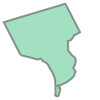

In [29]:
fieldShape = field['geometry'][0] # Define the geometry as a shapely polygon
fieldShape

Below, combine a plot of the farm field boundary (combine two `geoviews` plots using `*`) with a basemap layer.

In [30]:
# Use geoviews to combine a basemap with the shapely polygon of our Region of Interest (ROI)
base = gv.tile_sources.EsriImagery.opts(width=500, height=500)
farmField = gv.Polygons(fieldShape).opts(line_color='yellow', color=None)

base * farmField

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

The farm field used in this example use case is located northwest of Chico, CA. 

Now, add the bounding box of the region of interest to the CMR-STAC API Search query using the `bbox` parameter.

In [31]:
bbox = f'{fieldShape.bounds[0]},{fieldShape.bounds[1]},{fieldShape.bounds[2]},{fieldShape.bounds[3]}'    # Defined from ROI bounds
params['bbox'] = bbox                                                                                    # Add ROI to params
params

{'limit': 100,
 'bbox': '-122.0622682571411,39.897234301806,-122.04918980598451,39.91309383703065'}

In [32]:
search_response = r.post(lp_search, json=params).json()    # Send POST request with bbox included
print(f"{len(search_response['features'])} items found!")

100 items found!


### 3.2 Temporal Querying <a id="3.2"></a>

Finally, you can narrow your search to a specific time period of interest using the `datetime` parameter. Here we have set the time period of interest from September 2020 through March 2021. Additional information on setting temporal searches can be found in the [NASA CMR Documentation](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#temporal-range-searches). 

In [33]:
date_time = "2021-07-01T00:00:00Z/2021-08-31T23:59:59Z"    # Define start time period / end time period
params['datetime'] = date_time
params

{'limit': 100,
 'bbox': '-122.0622682571411,39.897234301806,-122.04918980598451,39.91309383703065',
 'datetime': '2021-07-01T00:00:00Z/2021-08-31T23:59:59Z'}

In [34]:
search_response = r.post(lp_search, json=params).json()    # Send POST request with datetime included
print(f"{len(search_response['features'])} items found!")

47 items found!


Next, add the `shortname` for the HLSS30 v2.0 product (HLSS30.v2.0) to the params dictionary, and query the CMR-STAC LPCLOUD search endpoint for just HLSS30 items.

In [35]:
s30_id = "HLSS30.v2.0"
params["collections"] = [s30_id]

In [36]:
# Search for the HLSS30 items of interest:
s30_items = r.post(lp_search, json=params).json()['features']  # Send POST request with collection included
len(s30_items)

24

Append the HLSL30 V2.0 Product shortname (ID) to the list under the `collections` parameter.

In [37]:
l30_id = "HLSL30.v2.0"
params["collections"].append(l30_id)
params

{'limit': 100,
 'bbox': '-122.0622682571411,39.897234301806,-122.04918980598451,39.91309383703065',
 'datetime': '2021-07-01T00:00:00Z/2021-08-31T23:59:59Z',
 'collections': ['HLSS30.v2.0', 'HLSL30.v2.0']}

The `collections` parameter is a list and can include multiple product collection short names.

In [38]:
# Search for the HLSS30 and HLSL30 items of interest:
hls_items = r.post(lp_search, json=params).json()['features']    # Send POST request with S30 and L30 collections included
len(hls_items)

30

In [39]:
del bbox, date_time, field, lim, lp_links, lp_search, search_response, s30_items    # Remove

---

## 4. Extracting HLS COGs from the Cloud <a id="extracthls"></a>

In this section, configure `gdal` and `rasterio` to use `vsicurl` to access the cloud assets that we are interested in, and read them directly into memory without needing to download the files. 

Accessing data stored in the Cloud is done using Python libraries that leverage GDAL's virtual file systems. Whether you are running this code in the Cloud or in a local workspace, GDAL configurations must be set in order to successfully access the HLS COG files.

In [40]:
# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')

## 4.1 Subset by Band <a id="2.1"></a>

View the contents of the first item.

In [41]:
h = hls_items[0]
h

{'type': 'Feature',
 'id': 'HLS.S30.T10TEK.2021182T185921.v2.0',
 'stac_version': '1.0.0',
 'stac_extensions': ['https://stac-extensions.github.io/eo/v1.0.0/schema.json'],
 'collection': 'HLSS30.v2.0',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-121.9647512, 39.656993],
    [-121.7065142, 40.3914601],
    [-121.7016593, 40.6435572],
    [-123.0002366, 40.6508565],
    [-123.0002332, 39.661607],
    [-121.9647512, 39.656993]]]},
 'bbox': [-123.000237, 39.656993, -121.701659, 40.650856],
 'links': [{'rel': 'self',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v2.0/items/HLS.S30.T10TEK.2021182T185921.v2.0'},
  {'rel': 'parent',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v2.0'},
  {'rel': 'collection',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v2.0'},
  {'rel': 'root', 'href': 'https://cmr.earthdata.nasa.gov/stac/'},
  {'rel': 'provider', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCL

Subset by band by filtering to only include the NIR, Red, Blue, and Quality (Fmask) layers in the list of links to access. Below you can find the different band numbers for each of the two products.

### Sentinel 2:
    - "narrow" NIR = B8A
    - Red = B04
    - Blue = B02  
    - Quality = Fmask
### Landsat 8:
    - NIR = B05
    - Red = B04
    - Blue = B02  
    - Quality = Fmask

In [42]:
evi_band_links = []

# Define which HLS product is being accessed
if h['assets']['browse']['href'].split('/')[4] == 'HLSS30.015':
    evi_bands = ['B8A', 'B04', 'B02', 'Fmask'] # NIR RED BLUE Quality for S30
else:
    evi_bands = ['B05', 'B04', 'B02', 'Fmask'] # NIR RED BLUE Quality for L30

# Subset the assets in the item down to only the desired bands
for a in h['assets']: 
    if any(b == a for b in evi_bands):
        evi_band_links.append(h['assets'][a]['href'])
for e in evi_band_links: print(e)

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B05.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B04.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.Fmask.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B02.tif


Remember from above that you can always quickly load in the browse image to get a quick view of the item.

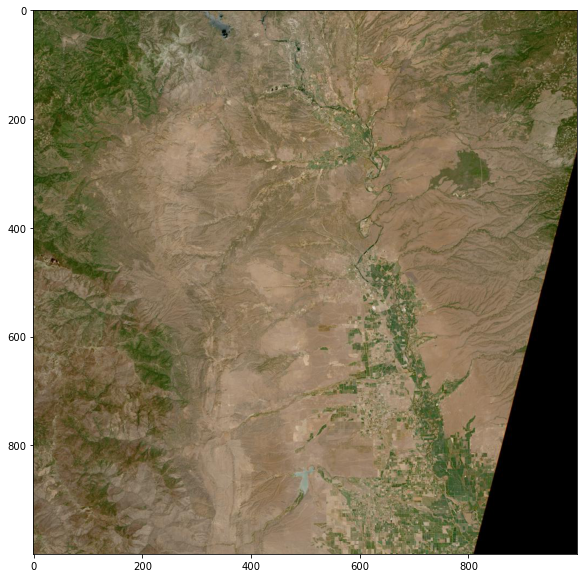

In [43]:
image = io.imread(h['assets']['browse']['href'])  # Load jpg browse image into memory

# Basic plot of the image
plt.figure(figsize=(10,10))              
plt.imshow(image)
plt.show()

Above, we see a partly cloudy observation over the northern Central Valley of California. 

In [44]:
del image # Remove the browse image

### 4.2 Load a Spatially Subset HLS COG into Memory <a id="2.1"></a>

Before accessing and loading the COGs into memory, run the cell below to check and make sure that you have a netrc file set up with your [NASA Earthdata Login](https://urs.earthdata.nasa.gov/) credentials, which will be needed to access the HLS files in the cells that follow. If you do not have a netrc file set up on your OS, the cell below should prompt you for your NASA Earthdata Login username and password.

In [45]:
# AUTHENTICATION CONFIGURATION
from netrc import netrc
from subprocess import Popen, DEVNULL, STDOUT
from getpass import getpass
from sys import platform

urs = 'urs.earthdata.nasa.gov'    # Earthdata URL to call for authentication
prompts = ['Enter NASA Earthdata Login Username \n(or create an account at urs.earthdata.nasa.gov): ',
           'Enter NASA Earthdata Login Password: ']

# Determine if netrc file exists, and if it includes NASA Earthdata Login Credentials
if 'win' in platform:
    nrc = '_netrc'
else:
    nrc = '.netrc'
try:
    netrcDir = os.path.expanduser(f"~/{nrc}")
    netrc(netrcDir).authenticators(urs)[0]
    del netrcDir

# If not, create a netrc file and prompt user for NASA Earthdata Login Username/Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")

    # Windows OS won't read the netrc unless this is set
    Popen(f'setx HOME {homeDir}', shell=True, stdout=DEVNULL);

    if nrc == '.netrc':
        Popen(f'touch {homeDir + os.sep}{nrc} | chmod og-rw {homeDir + os.sep}{nrc}', shell=True, stdout=DEVNULL, stderr=STDOUT);

    # Unable to use touch/chmod on Windows OS
    Popen(f'echo machine {urs} >> {homeDir + os.sep}{nrc}', shell=True)
    Popen(f'echo login {getpass(prompt=prompts[0])} >> {homeDir + os.sep}{nrc}', shell=True)
    Popen(f'echo password {getpass(prompt=prompts[1])} >> {homeDir + os.sep}{nrc}', shell=True)
    del homeDir

# Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen(f'echo machine {urs} >> {homeDir + os.sep}{nrc}', shell=True)
    Popen(f'echo login {getpass(prompt=prompts[0])} >> {homeDir + os.sep}{nrc}', shell=True)
    Popen(f'echo password {getpass(prompt=prompts[1])} >> {homeDir + os.sep}{nrc}', shell=True)
    del homeDir
del urs, prompts

Read the file using `rasterio`. 

In [46]:
# Use vsicurl to load the data directly into memory (be patient, may take a few seconds)
for e in evi_band_links:
    print(e)
    if e.rsplit('.', 2)[-2] == evi_bands[0]:      # NIR index
        nir = rio.open(e)
    elif e.rsplit('.', 2)[-2] == evi_bands[1]:    # red index
        red = rio.open(e)
    elif e.rsplit('.', 2)[-2] == evi_bands[2]:    # blue index
        blue = rio.open(e)
    elif e.rsplit('.', 2)[-2] == evi_bands[3]:    # Fmask index
        fmask = rio.open(e)
print("The COGs have been loaded into memory!")

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B05.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B04.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.Fmask.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B02.tif
The COGs have been loaded into memory!


> **NOTE:** Getting an error in the section above? Accessing these files in the cloud requires you to authenticate using your NASA Earthdata Login account. You will need to have a netrc file set up containing those credentials in your home directory in order to successfully run the code below. Check out the `Setting up a netrc File` section in the [README](https://git.earthdata.nasa.gov/projects/LPDUR/repos/hls-tutorial/browse/README.md).

Below, take the farm field `shapely` polygon and convert it from lat/lon (EPSG: 4326) into the [native projection of HLS](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/#hls-tiling-system), UTM (aligned to the Military Grid Reference System). This must be done in order to use the Region of Interest (ROI) to subset the COG that is being pulled into memory--it must be in the native projection of the data being extracted. 

In [47]:
geo_CRS = Proj('+proj=longlat +datum=WGS84 +no_defs', preserve_units=True)  # Source coordinate system of the ROI
utm = pyproj.Proj(nir.crs)                                                  # Destination coordinate system
project = pyproj.Transformer.from_proj(geo_CRS, utm)                        # Set up the transformation
fsUTM = transform(project.transform, fieldShape)                            # Apply reprojection

Now, we can use the ROI to mask any pixels that fall outside of it and crop to the bounding box using `rasterio`. This greatly reduces the amount of data that are needed to load into memory. 

In [48]:
nir_array, nir_transform = rio.mask.mask(nir, [fsUTM], crop=True)  # Extract the data for the ROI and clip to that bbox

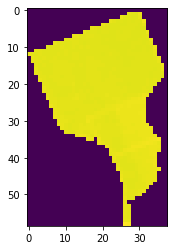

In [49]:
plt.imshow(nir_array[0]);  # Quick visual to assure that it worked

Above, you can see that the data have been loaded into memory already subset to our ROI. Next, load in the red and blue bands.

In [50]:
red_array, _ = rio.mask.mask(red,[fsUTM],crop=True)
blue_array, _ = rio.mask.mask(blue,[fsUTM],crop=True)
print('Data is loaded into memory!')

Data is loaded into memory!


In [51]:
del a, e, evi_band_links, evi_bands  # Remove variables that are no longer needed

---
## 5. Processing HLS Data <a id="processhls"></a>

In this section, read the file metadata to retrieve and apply the scale factor, filter out nodata values, define a function to calculate EVI, and execute the EVI function on the data loaded into memory. After that, perform quality filtering to screen out any poor quality observations. 

### 5.1 Apply Scale Factor and Calculate EVI <a id="2.1"></a>

Read the file metadata.

In [52]:
nir.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -9999.0,
 'width': 3660,
 'height': 3660,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["UTM Zone 10, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not_specified_based_on_WGS_84_spheroid",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(30.0, 0.0, 499980.0,
        0.0, -30.0, 4500000.0)}

Apply the scale factor to each array, and set the no-data values to `nan`.

In [53]:
# Grab scale factor from metadata and apply to each band
nir_scaled = nir_array[0] * nir.scales[0]
red_scaled = red_array[0] * red.scales[0]
blue_scaled = blue_array[0] * blue.scales[0]

In [54]:
# Set all nodata values to nan
nir_scaled[nir_array[0]==nir.nodata] = np.nan 
red_scaled[red_array[0]==red.nodata] = np.nan 
blue_scaled[blue_array[0]==blue.nodata] = np.nan 

Define a function for calculating EVI from the NIR, Red, and Blue bands.

In [55]:
def evi(red, blue, nir):
      return 2.5 * (nir - red) / (nir + 6.0 * red - 7.5 * blue + 1.0) 

Below, apply the EVI function on the scaled data.

In [56]:
evi_scaled = evi(red_scaled, blue_scaled, nir_scaled) # Generate EVI array

Go back to the STAC Item and grab the observation date to add to the plot below.

In [57]:
eviDate = h['properties']['datetime'].split('T')[0]  # Set the observation date to a variable

Next, plot the results using `matplotlib`.

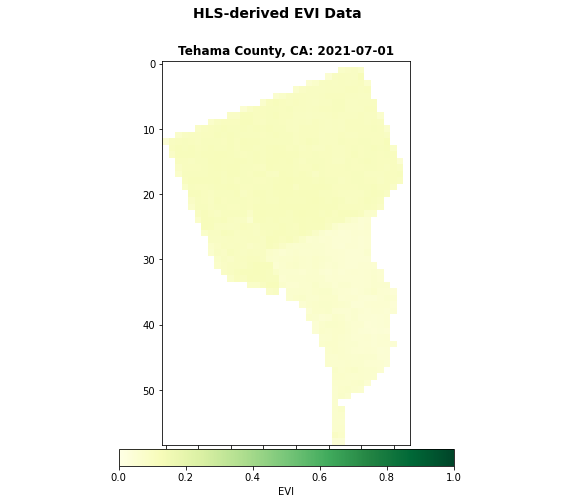

In [58]:
# Ignore matplotlib warnings
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize = (10,7.5))    # Set the figure size (x,y)
plt.axis('off')                         # Remove the axes' values

fig.suptitle('HLS-derived EVI Data', fontsize=14, fontweight='bold')  # Make a figure title
ax = fig.add_subplot(111)                                                                  # Make a subplot
ax.set_title(f'Tehama County, CA: {eviDate}', fontsize=12, fontweight='bold')              # Add figure subtitle
ax1 = plt.gca()                                                                            # Get current axes

# Plot the array, using a colormap and setting a custom linear stretch 
im = plt.imshow(evi_scaled, vmin=0, vmax=1, cmap='YlGn');

# Add a colormap legend
plt.colorbar(im, orientation='horizontal', fraction=0.047, pad=0.009, label='EVI', shrink=0.6).outline.set_visible(True)

Above, notice that our farm field boundary actually appears to be comprised of two separate fields, one being much greener than the other. 

### 5.2 Quality Filtering <a id="2.1"></a>

In this section, load in the `Fmask` quality layer, breakdown the bit-encoded information, define good quality observations, and apply a mask to the EVI layer using pixels with good quality as defined by the `Fmask`.

In [59]:
fmask_array, _ = rio.mask.mask(fmask, [fsUTM], crop=True)  # Load in the Quality data

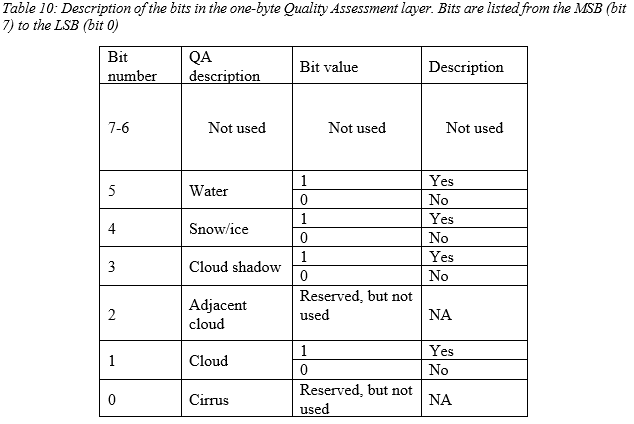

The quality table above can be found in section 6.4 of the [HLS V2.0 User Guide](https://lpdaac.usgs.gov/documents/1326/HLS_User_Guide_V2.pdf).

Looking at the table above, using the left column, you can see there are 7 bitwords, or bit groupings for this quality layer. Below, set the number of bitwords and the number of bits per bitword.

In [60]:
bitword_order = (1, 1, 1, 1, 1, 1, 2)  # set the number of bits per bitword
num_bitwords = len(bitword_order)      # Define the number of bitwords based on your input above
total_bits = sum(bitword_order)        # Should be 8, 16, or 32 depending on datatype

Next, list all of the unique values present in the quality layer, and convert from decimal to binary form. The section below will loop through and convert each quality value present in the list to its binary form, and use the bitword order and information from the quality table above to determine if a value is deemed "good quality".

For this exercise, we will define the following as **good quality**:
  - Cloud == 0 (No Cloud)  
  - Cloud shadow == 0 (No Cloud shadow)  
  - Snow/ice == 0 (No Snow/ice present)  
  - Water == 0 (No Water present)

In [61]:
qVals = list(np.unique(fmask_array))  # Create a list of unique values that need to be converted to binary and decoded
all_bits = list()
goodQuality = []
for v in qVals:
    all_bits = []
    bits = total_bits
    i = 0
    
    # Convert to binary based on the values and # of bits defined above:
    bit_val = format(v, 'b').zfill(bits)
    print('\n' + str(v) + ' = ' + str(bit_val))
    all_bits.append(str(v) + ' = ' + str(bit_val))

    # Go through & split out the values for each bit word based on input above:
    for b in bitword_order:
        prev_bit = bits
        bits = bits - b
        i = i + 1
        if i == 1:
            bitword = bit_val[bits:]
            print(' Bit Word ' + str(i) + ': ' + str(bitword))
            all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword)) 
        elif i == num_bitwords:
            bitword = bit_val[:prev_bit]
            print(' Bit Word ' + str(i) + ': ' + str(bitword))
            all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword))
        else:
            bitword = bit_val[bits:prev_bit]
            print(' Bit Word ' + str(i) + ': ' + str(bitword))
            all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword))
            
    # 2, 4, 5, 6 are the bits used. All 4 should = 0 if no clouds, cloud shadows were present, and pixel is not snow/ice/water
    if int(all_bits[2].split(': ')[-1]) + int(all_bits[4].split(': ')[-1]) + \
    int(all_bits[5].split(': ')[-1]) + int(all_bits[6].split(': ')[-1]) == 0:
        goodQuality.append(v)


64 = 01000000
 Bit Word 1: 0
 Bit Word 2: 0
 Bit Word 3: 0
 Bit Word 4: 0
 Bit Word 5: 0
 Bit Word 6: 0
 Bit Word 7: 01

128 = 10000000
 Bit Word 1: 0
 Bit Word 2: 0
 Bit Word 3: 0
 Bit Word 4: 0
 Bit Word 5: 0
 Bit Word 6: 0
 Bit Word 7: 10

255 = 11111111
 Bit Word 1: 1
 Bit Word 2: 1
 Bit Word 3: 1
 Bit Word 4: 1
 Bit Word 5: 1
 Bit Word 6: 1
 Bit Word 7: 11


So if we look above, a quality value of 0 indicates the following:
> Cloud = No  
Cloud Shadow = No  
Snow/ice = No  
Water = No

Indicating that any pixel with a quality value of 0 is good quality. 

In [62]:
goodQuality

[64, 128]

Above, only pixels with an _Fmask_ value of 0 will be included after masking.

Below, mask the EVI array using the quality mask. Notice that invert is set to "True" here, meaning that you do not want to exclude the good quality value of 0, but rather exclude all other values.

In [63]:
evi_band = np.ma.MaskedArray(evi_scaled, np.in1d(fmask_array, goodQuality, invert=True))  # Apply QA mask to the EVI data
evi_band = np.ma.filled(evi_band, np.nan)                                                 # Set masked data to nan

### 5.3 Export to COG <a id="2.1"></a>

In this section, create an output filename and export the quality filtered EVI to COG. 

In [64]:
originalName = nir.name.rsplit('/', 1)[-1]  # Grab the original granule name
originalName

'HLS.S30.T10TEK.2021182T185921.v2.0.B05.tif'

The standard format  for HLS S30 V2.0 and HLS L30 V2.0 filenames is as follows:
> **HLS.S30/HLS.L30**: Product Short Name    
**T10TEK**: MGRS Tile ID (T+5-digits)  
**2020273T190109**: Julian Date and Time of Acquisition (YYYYDDDTHHMMSS)  
**v2.0**: Product Version   
**B8A/B05**: Spectral Band  
**.tif**: Data Format (Cloud Optimized GeoTIFF)  

For additional information on HLS naming conventions, be sure to check out the [HLS Overview Page](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/#hls-naming-conventions).

In [65]:
outName = f"{originalName.split('.B')[0]}_EVI.tif"  # Generate output name from the original filename
tempName = 'temp.tif'                               # Set up temp file
outName

'HLS.S30.T10TEK.2021182T185921.v2.0_EVI.tif'

The process of successfully writing a valid COG needs to be completed in a certain order. Below, add the overviews to the output GeoTIFF first, and then add tiling and compression.


In [66]:
# Create output GeoTIFF with overviews
evi_tif = rio.open(tempName, 'w', driver='GTiff', height=evi_band.shape[0], width=evi_band.shape[1], count=1,
                   dtype=str(evi_band.dtype), crs=nir.crs, transform=nir_transform)

evi_tif.write(evi_band, 1)                                    # Write the EVI band to the newly created GeoTIFF
evi_tif.build_overviews([2, 4, 8], Resampling.average)        # Calculate overviews
evi_tif.update_tags(ns='rio_overview', resampling='average')  # Update tags

# Copy the profile, add tiling and compression
kwds = evi_tif.profile
kwds['tiled'] = True
kwds['compress'] = 'LZW'

In [67]:
evi_tif.overviews(1)  # Print overviews

[2, 4, 8]

In [68]:
evi_tif.close()  # Close file

Now that the overviews have been created, re-open the file, copy the file attributes (adding tiling and LZW compression), and write back to the output filename.

In [69]:
# Open temp file and export as valid cog
with rio.open(tempName, 'r+') as src:
    copy(src, outName, copy_src_overviews=True, **kwds)
src.close(), os.remove(tempName);

In [70]:
src.close(), nir.close(), red.close(), fmask.close(), blue.close()
del nir_array, red_array, blue_array, red_scaled, blue_scaled, nir_scaled, i, originalName, outName, prev_bit, qVals, v
del all_bits, b, bit_val, bits, bitword, eviDate, evi_band, evi_scaled, fmask_array, goodQuality, h

---

## 6. Automation <a id="automation"></a>

In this section,  automate sections 4-5 for each HLS item that intersects our spatiotemporal subset of interest. Loop through each item and subset to the desired bands, load the spatial subset into memory, apply the scale factor, calculate EVI, quality filter, and export as a Cloud Optimized GeoTIFF. 

In [71]:
len(hls_items)

30

Be patient with the for loop below, it may take a few minutes to complete. 

In [72]:
# Now put it all together and loop through each of the files, visualize, calculate statistics on EVI, and export
for j, h in enumerate(hls_items):
    outName = h['assets']['browse']['href'].split('/')[-1].replace('.jpg', '_EVI.tif')
    
    # Check if file already exists in output directory, if yes--skip that file and move to the next observation
    if os.path.exists(outName):
        print(f"{outName} has already been processed and is available in this directory, moving to next file.")
        continue
    try:
        evi_band_links = []
        if h['assets']['browse']['href'].split('/')[4] == 'HLSS30.015':
            evi_bands = ['B8A', 'B04', 'B02', 'Fmask'] # NIR RED BLUE FMASK
        else:
            evi_bands = ['B05', 'B04', 'B02', 'Fmask'] # NIR RED BLUE FMASK
        for a in h['assets']: 
            if any(b == a for b in evi_bands):
                evi_band_links.append(h['assets'][a]['href'])

        # Use vsicurl to load the data directly into memory (be patient, may take a few seconds)
        for e in evi_band_links:
            if e.rsplit('.', 2)[-2] == evi_bands[0]: # NIR index
                nir = rio.open(e)
            elif e.rsplit('.', 2)[-2] == evi_bands[1]: # red index
                red = rio.open(e)
            elif e.rsplit('.', 2)[-2] == evi_bands[2]: # blue index
                blue = rio.open(e)
            elif e.rsplit('.', 2)[-2] == evi_bands[3]: # fmask index
                fmask = rio.open(e)

        # load data and scale
        nir_array,nir_transform = rio.mask.mask(nir,[fsUTM],crop=True)
        red_array, _ = rio.mask.mask(red,[fsUTM],crop=True)
        blue_array, _ = rio.mask.mask(blue,[fsUTM],crop=True)
        nir_scaled = nir_array[0] * nir.scales[0]
        red_scaled = red_array[0] * red.scales[0]
        blue_scaled = blue_array[0] * blue.scales[0]
        nir_scaled[nir_array[0]==nir.nodata] = np.nan 
        red_scaled[red_array[0]==red.nodata] = np.nan 
        blue_scaled[blue_array[0]==blue.nodata] = np.nan 

        # Generate EVI
        evi_scaled = evi(red_scaled, blue_scaled, nir_scaled)

        # Quality Filter the data
        fmask_array, _ = rio.mask.mask(fmask,[fsUTM],crop=True)
        qVals = list(np.unique(fmask_array))
        all_bits = list()
        goodQuality = []
        for v in qVals:
            all_bits = []
            bits = total_bits
            i = 0
            # Convert to binary based on the values and # of bits defined above:
            bit_val = format(v, 'b').zfill(bits)
            all_bits.append(str(v) + ' = ' + str(bit_val))

            # Go through & split out the values for each bit word based on input above:
            for b in bitword_order:
                prev_bit = bits
                bits = bits - b
                i = i + 1
                if i == 1:
                    bitword = bit_val[bits:]
                    all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword)) 
                elif i == num_bitwords:
                    bitword = bit_val[:prev_bit]
                    all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword))
                else:
                    bitword = bit_val[bits:prev_bit]
                    all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword))

            # 2, 4, 5, 6 are the bits used. All should = 0 if no clouds, cloud shadows were present & pixel is not snow/ice/water
            if int(all_bits[2].split(': ')[-1]) + int(all_bits[4].split(': ')[-1]) + \
            int(all_bits[5].split(': ')[-1]) + int(all_bits[6].split(': ')[-1]) == 0:
                goodQuality.append(v)
        evi_band = np.ma.MaskedArray(evi_scaled, np.in1d(fmask_array, goodQuality, invert=True))  # Apply QA mask to the EVI data
        evi_band = np.ma.filled(evi_band, np.nan)
        
        # Remove any observations that are entirely fill value
        if np.nansum(evi_band) == 0.0:
            print(f"File: {h['assets']['browse']['href'].split('/')[-1].rsplit('.', 1)[0]} ({h['id']}) was entirely fill values and will not be exported.")
            continue
        tempName = "temp.tif"
        # Create output GeoTIFF with overviews
        evi_tif = rio.open(tempName, 'w', driver='GTiff', height=evi_band.shape[0], width=evi_band.shape[1], count=1,
                           dtype=str(evi_band.dtype), crs=nir.crs, transform=nir_transform)
        evi_tif.write(evi_band, 1)
        evi_tif.build_overviews([2, 4, 8], Resampling.average)
        evi_tif.update_tags(ns='rio_overview', resampling='average')
        
        # Copy the profile, add tiling and compression
        kwds = evi_tif.profile
        kwds['tiled'] = True
        kwds['compress'] = 'LZW'
        evi_tif.close()
        
        # Open temp file and export as valid cog
        with rio.open(tempName, 'r+') as src:
            copy(src, outName, copy_src_overviews=True, **kwds)
        src.close(), os.remove(tempName);

    except:
        print(f"Unable to access file: {h['assets']['browse']['href'].split('/')[-1].rsplit('.', 1)[0]} ({h['id']})")
    print(f"Processing file {j+1} of {len(hls_items)}")

HLS.S30.T10TEK.2021182T185921.v2.0_EVI.tif has already been processed and is available in this directory, moving to next file.
Processing file 2 of 30
Processing file 3 of 30
Processing file 4 of 30
Processing file 5 of 30
Processing file 6 of 30
Processing file 7 of 30
Processing file 8 of 30
Processing file 9 of 30
Processing file 10 of 30
Processing file 11 of 30
Processing file 12 of 30
Processing file 13 of 30
Processing file 14 of 30
Processing file 15 of 30
Processing file 16 of 30
Processing file 17 of 30
Processing file 18 of 30
Processing file 19 of 30
Processing file 20 of 30
Processing file 21 of 30
Processing file 22 of 30
File: HLS.S30.T10TEK.2021227T185919.v2.0 (HLS.S30.T10TEK.2021227T185919.v2.0) was entirely fill values and will not be exported.
File: HLS.S30.T10TEK.2021229T184921.v2.0 (HLS.S30.T10TEK.2021229T184921.v2.0) was entirely fill values and will not be exported.
Processing file 25 of 30
Processing file 26 of 30
Processing file 27 of 30
Processing file 28 of 3

Now there should be multiple COGs exported to your working directory, that will be used in Section 7 to stack into a time series. 

In [73]:
# Remove variables that are no longer needed and close the files that were read in memory
del all_bits, b, bit_val, bits, bitword, bitword_order, blue_array, blue_scaled, e, evi_band, evi_band_links, evi_bands
del evi_scaled, fmask_array, goodQuality, h, hls_items, i, nir_array, nir_scaled, nir_transform, num_bitwords, outName
del prev_bit, qVals, red_array, red_scaled, stac, total_bits, v
nir.close(), red.close(), fmask.close(), blue.close();

---

## 7. Stacking HLS Data <a id="stackhls"></a>

In this section, open multiple HLS-derived EVI COGs and stack them into an `xarray` data array. 

### 7.1 Open and Stack using Xarray<a id="4.1"></a>

[`Xarray`](http://xarray.pydata.org/en/stable/) extends and combines much of the core functionality from both the Pandas library and Numpy, hence making it very good at handling multi-dimensional (N-dimensional) datasets that contain labels (e.g., variable names or dimension names).

List the files in the current working directory.

In [74]:
eviFiles = [o for o in os.listdir() if o.endswith('EVI.tif')]  # List EVI COGs
eviFiles

['HLS.L30.T10TEK.2021183T185121.v2.0_EVI.tif',
 'HLS.L30.T10TEK.2021192T184511.v2.0_EVI.tif',
 'HLS.L30.T10TEK.2021199T185124.v2.0_EVI.tif',
 'HLS.L30.T10TEK.2021215T185132.v2.0_EVI.tif',
 'HLS.L30.T10TEK.2021224T184524.v2.0_EVI.tif',
 'HLS.L30.T10TEK.2021240T184529.v2.0_EVI.tif',
 'HLS.S30.T10TEK.2021182T185921.v2.0_EVI.tif',
 'HLS.S30.T10TEK.2021187T185919.v2.0_EVI.tif',
 'HLS.S30.T10TEK.2021189T184921.v2.0_EVI.tif',
 'HLS.S30.T10TEK.2021192T185921.v2.0_EVI.tif',
 'HLS.S30.T10TEK.2021194T184919.v2.0_EVI.tif',
 'HLS.S30.T10TEK.2021197T185919.v2.0_EVI.tif',
 'HLS.S30.T10TEK.2021199T184921.v2.0_EVI.tif',
 'HLS.S30.T10TEK.2021202T185921.v2.0_EVI.tif',
 'HLS.S30.T10TEK.2021204T184919.v2.0_EVI.tif',
 'HLS.S30.T10TEK.2021207T185919.v2.0_EVI.tif',
 'HLS.S30.T10TEK.2021209T184921.v2.0_EVI.tif',
 'HLS.S30.T10TEK.2021212T185921.v2.0_EVI.tif',
 'HLS.S30.T10TEK.2021214T184919.v2.0_EVI.tif',
 'HLS.S30.T10TEK.2021217T185919.v2.0_EVI.tif',
 'HLS.S30.T10TEK.2021219T184921.v2.0_EVI.tif',
 'HLS.S30.T10

Loop through and open each file, and add to an xarray data array.

In [75]:
for i, e in enumerate(eviFiles):
    time = datetime.strptime(e.rsplit('.v2.0', 1)[0].rsplit('.', 1)[-1], '%Y%jT%H%M%S')  # Grab acquisition time from filename
    
    # Need to set up the xarray data array for the first file
    if i == 0:
        eviStack = xr.open_rasterio(e)                                      # Open file using rasterio
        eviStack = eviStack.squeeze(drop=True)
        eviStack.coords['time'] = np.array(time)                            # Define time coordinate
        eviStack = eviStack.rename({'x':'lon', 'y':'lat', 'time':'time'})   # Rename coordinates
        eviStack = eviStack.expand_dims(dim='time')
    else:
        eviS = xr.open_rasterio(e)
        eviS = eviS.squeeze(drop=True)
        eviS.coords['time'] = np.array(time)
        eviS = eviS.rename({'x':'lon', 'y':'lat', 'time':'time'})
        eviS = eviS.expand_dims(dim='time')
        eviStack = xr.concat([eviStack, eviS], dim='time')                  # concatenate the new array to the data array
eviStack.name = 'EVI'

Xarray has two fundamental  data structures. A `Dataset` holds multiple variables that potentially share the same coordinates and global metadata for the file (see above). A `DataArray` contains a single multi-dimensional variable and its coordinates, attributes, and metadata. Data values can be pulled out of the DataArray as a `numpy.ndarray` using the `values` attribute.

In [76]:
eviStack

<xarray.DataArray 'EVI' (time: 28, lat: 59, lon: 38)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat      (lat) float64 4.419e+06 4.419e+06 4.418e+06 ... 4.417e+06 4.417e+06
  * lon      (lon) float64 5.802e+05 5.802e+05 5.802e+05 ... 5.812e+05 5.813e+05
  * time     (time) datetime64[ns] 2021-07-02T18:51:21 ... 2021-08-30T18:59:21
Attributes:
    transform:      (30.0, 0.0, 580140.0, 0.0, -30.0, 4418550.0)
    crs:            +proj=utm +zone=10 +ellps=WGS84 +units=m +no_defs=True
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

Above, notice we have created a data array called `EVI` that has lat (y) and lon (x) coordinates, as well as the z dimension, which is time. This allows us to plot and visualize the HLS-derived EVI data as a time series sequentially by time and in geographic space using the lat/lon coordinates.

Below, use the xarray's `.sortby()` function to assure that the data for both L30 and S30 are arranged by time.

In [77]:
eviStack = eviStack.sortby(eviStack.time)

#### Looking to learn more specifically about using xarray for time series analysis? Check out the [Using the AρρEEARS API in a Landsat ARD Workflow - Getting Started](https://lpdaac.usgs.gov/resources/e-learning/using-the-a%CF%81%CF%81eears-api-in-a-landsat-ard-workflow-getting-started/) Jupyter Notebook tutorial. 

### 7.2 Visualize Stacked Time Series<a id="4.1"></a>

Below, use the [`hvPlot`](https://hvplot.pyviz.org/index.html) and [`holoviews`](https://www.holoviews.org/) packages to create an interactive time series plot of the HLS derived EVI data.

In [78]:
# set the x, y, and z (groupby) dimensions, add a colormap/bar and other parameters.
title = 'HLS-derived EVI over an agricultural field in northern California'
eviStack.hvplot(x='lon', y='lat',groupby='time', cmap='YlGn', width=600, height=600, colorbar=True).opts(clim=(0.0, 1.0),
                                                                                                        title=title)

:DynamicMap   [time]
   :Image   [lon,lat]   (EVI)

Next, add a basemap layer to provide better context of the areas surrounding our region of interest.

In [79]:
ecrs = pyproj.CRS.to_epsg(pyproj.CRS.from_proj4(eviStack.crs))  # Define CRS

# Use holoviews to create a plot grouped by time and with a specific stretch and colorbar/map applied and shown
hls_stack = eviStack.hvplot(x='lon', y='lat', crs=ecrs, groupby='time', cmap='YlGn', colorbar=True).opts(clim=(0.0, 1.0),
                                                                                                         title=title)

base * hls_stack  # Add in the basemap created earlier

:DynamicMap   [time]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [lon,lat]   (EVI)

Looking at the time series above, this farm field is likely a field of walnut trees. Notice the higher EVI (greens) during the summer and browning that is likely occurring from dry conditions as the time series progresses later into autumn. 

Since the data is in an xarray we can intuitively slice or reduce the dataset. Let's select a single time slice from the EVI variable.

In [80]:
sTime = '2021-07-11T18:45:11'  # Single date
eviStack.sel(time=sTime)  # Select a single time slice and pull out of xarray data array

<xarray.DataArray 'EVI' (lat: 59, lon: 38)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 4.419e+06 4.419e+06 4.418e+06 ... 4.417e+06 4.417e+06
  * lon      (lon) float64 5.802e+05 5.802e+05 5.802e+05 ... 5.812e+05 5.813e+05
    time     datetime64[ns] 2021-07-11T18:45:11
Attributes:
    transform:      (30.0, 0.0, 580140.0, 0.0, -30.0, 4418550.0)
    crs:            +proj=utm +zone=10 +ellps=WGS84 +units=m +no_defs=True
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

You can use slicing to plot data only for a specific observation, for example.

In [81]:
eviStack.sel(time=sTime).hvplot.box(by=['time'], rot=45, box_fill_color='lightblue', padding=0.1, width=450, height=350)

:BoxWhisker   [Variable]   (value)

Now, plot the time series as boxplots showing the distribution of EVI values for our farm field.

In [82]:
# Select all observations from 2020 and plot each as a boxplot showing the distribution of EVI values for this field
eviStack.hvplot.box('EVI', by=['time'], rot=45, box_fill_color='lightblue', padding=0.1, width=800, height=450)

:BoxWhisker   [time]   (EVI)

Again, the statistics appear to support the conclusion that greener conditions prevailed in the summer of 2020 vs. later in autumn.

### 7.3 Export Statistics<a id="4.1"></a>

Next, calculate statistics for each observation and export to CSV. 

In [83]:
# xarray allows you to easily calculate a number of statistics
evi_min = eviStack.min(('lat', 'lon'))
evi_max = eviStack.max(('lat', 'lon'))
evi_mean = eviStack.mean(('lat', 'lon'))
evi_sd = eviStack.std(('lat', 'lon'))
evi_count = eviStack.count(('lat', 'lon'))
evi_median = eviStack.median(('lat', 'lon'))

We now have the `mean` and `standard deviation` for each time slice as well as the `maximum` and `minimum` values. Let's do some plotting! We will use the [`hvPlot`](https://hvplot.pyviz.org/index.html) package to create simple but interactive charts/plots. Hover your curser over the visualization to see the data values. 

In [84]:
evi_mean.hvplot.line()

:Curve   [time]   (EVI)

In [85]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Combine line plots for different statistics
stats = (evi_mean.hvplot.line(height=350, width=450, line_width=1.5, color='red', grid=True, padding=0.05).opts(title='Mean')+ 
    evi_sd.hvplot.line(height=350, width=450, line_width=1.5, color='red', grid=True, padding=0.05).opts(title='Standard Deviation')
    + evi_max.hvplot.line(height=350, width=450, line_width=1.5, color='red', grid=True, padding=0.05).opts(title='Max') + 
    evi_min.hvplot.line(height=350, width=450, line_width=1.5, color='red', grid=True, padding=0.05).opts(title='Min')).cols(2)
stats

:Layout
   .Curve.I   :Curve   [time]   (EVI)
   .Curve.II  :Curve   [time]   (EVI)
   .Curve.III :Curve   [time]   (EVI)
   .Curve.IV  :Curve   [time]   (EVI)

Remember that these graphs are also interactive--hover over the line to see the value for a given date. 

Finally, create a `pandas` dataframe with the statistics, and export to a CSV file. 

In [86]:
# Create pandas dataframe from dictionary
df = pd.DataFrame({'Min EVI': evi_min, 'Max EVI': evi_max, 
                   'Mean EVI': evi_mean, 'Standard Deviation EVI': evi_sd, 
                   'Median EVI': evi_median, 'Count': evi_count})

In [87]:
df.index = eviStack.time.data                       # Set the observation date as the index
df.to_csv('HLS-Derived_EVI_Stats.csv', index=True)  # Export to CSV

In [88]:
del eviStack

Success! You have now not only learned how to get started with HLS V2.0 data, but have also learned how to navigate cloud-native data using STAC, how to access subsets of COGs, and how to write COGs for your own outputs. Using this jupyter notebook as a workflow, you should now be able to switch to your specific region of interest and re-run the notebook. Good Luck!

<div class="alert alert-block alert-info">
    <h1> Contact Information </h1>
    <h3> Material written by LP DAAC<sup>1</sup> </h3>
    <ul>
        <b>Contact:</b> LPDAAC@usgs.gov <br> 
        <b>Voice:</b> +1-605-594-6116 <br>
        <b>Organization:</b> Land Processes Distributed Active Archive Center (LP DAAC) <br>
        <b>Website:</b> https://lpdaac.usgs.gov/ <br>
        <b>Date last modified:</b> 09-27-2021 <br>
    </ul>
    
<sup>1</sup>KBR Inc., contractor to the U.S. Geological Survey, Earth Resources Observation and Science (EROS) Center, Sioux Falls, South Dakota, 57198-001, USA. Work performed under USGS contract G15PD00467 for LP DAAC<sup>2</sup>.

<sup>2</sup>LP DAAC Work performed under NASA contract NNG14HH33I.
</div>